<a href="https://colab.research.google.com/github/adampotton/Group-3-gotta-catch-em-all-/blob/main/silwhowets_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from PIL import Image
import random
import os
import csv
import shutil
from google.colab import drive
from sklearn.model_selection import train_test_split
import os
from torchvision.transforms import v2
from torch.optim.lr_scheduler import ReduceLROnPlateau
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
drive.mount('/content/drive')
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive


In [107]:
# DATA LOADING

root_directory = "/content/drive/My Drive/PokemonData"
selected_subdirectory = "/content/drive/My Drive/SelectedPokemonData"

# Get a list of all folders in the PokemonData directory
all_folders = [f for f in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, f))]

# Select random folders
n = 10
selected_folders = random.sample(all_folders, n)
print(selected_folders)

# Remove and recreate selected subdirectory
shutil.rmtree(selected_subdirectory, ignore_errors=True)
os.makedirs(selected_subdirectory, exist_ok=True)

# Copy selected folders to the subdirectory
for folder_name in selected_folders:
    src_folder_path = os.path.join(root_directory, folder_name)
    dest_folder_path = os.path.join(selected_subdirectory, folder_name)
    shutil.copytree(src_folder_path, dest_folder_path)

# Define a common size for resizing images
common_size = (224, 224)

# Dictionary to store image arrays for selected folders
image_arrays_dict = {}

# Iterate over the selected folders in the subdirectory
for folder_name in selected_folders:
    folder_path = os.path.join(selected_subdirectory, folder_name)
    image_arrays = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".jpg", ".png")):
            image_path = os.path.join(folder_path, filename)
            img = Image.open(image_path).convert("RGB").resize(common_size, Image.ANTIALIAS)
            img_array = np.array(img)
            image_arrays.append(img_array)
    image_arrays_dict[folder_name] = np.array(image_arrays)

# Combine all image arrays into a single array
all_images = np.concatenate(list(image_arrays_dict.values()), axis=0)

# Display selected classes and number of images per class
pokemon_classes = list(image_arrays_dict.keys())
num_images_per_class = [len(images) for images in image_arrays_dict.values()]
print(pokemon_classes)
print(num_images_per_class)

['Muk', 'Persian', 'Tentacruel', 'Pidgey', 'Jynx', 'Kingler', 'Aerodactyl', 'Dratini', 'Golem', 'Seel']


<ipython-input-107-d2e834dd3152>:37: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = Image.open(image_path).convert("RGB").resize(common_size, Image.ANTIALIAS)
<ipython-input-107-d2e834dd3152>:37: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = Image.open(image_path).convert("RGB").resize(common_size, Image.ANTIALIAS)
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


['Muk', 'Persian', 'Tentacruel', 'Pidgey', 'Jynx', 'Kingler', 'Aerodactyl', 'Dratini', 'Golem', 'Seel']
[149, 114, 124, 145, 141, 124, 112, 105, 142, 135]


In [108]:
# AUGMENTATION

transform = v2.Compose([
    v2.ToImage(),
    #v2.RandomHorizontalFlip(p=1),
    v2.RandomGrayscale(p=1),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.ColorJitter(contrast = 1000000)
])

aug_images = []
for img in all_images:
  aug_image = transform(img)
  aug_images.append(aug_image)

aug_images = torch.stack(aug_images)

all_labels = np.concatenate([np.full(num, i) for i, num in enumerate(num_images_per_class)])
combined_labels = np.concatenate([all_labels])


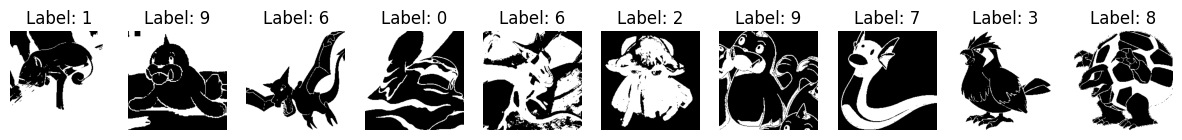

In [109]:
# SHOWING AUGMENTATION

combined_images = np.array(aug_images.permute(0, 2, 3, 1))
combined_images = (combined_images[:,:,:,0] + combined_images[:,:,:,1] + combined_images[:,:,:,2])/3

num_samples = 10  # You can adjust this number as needed
random_indices = random.sample(range(len(combined_images)), num_samples)

# Plot images with labels
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i, idx in enumerate(random_indices):
    image = combined_images[idx]
    label = combined_labels[idx]
    np_image = (image.squeeze() * 255).astype(np.uint8)
    np_image = 255 - np_image
    axes[i].imshow(np_image,cmap='gray')
    axes[i].set_title("Label: {}".format(label))
    axes[i].axis('off')

plt.show()


In [111]:
indices_to_delete = []

for i in range(len(combined_images)):
    image = combined_images[i]

    row_border_pixels = np.concatenate([image[0, :], image[-1, :]])

    column_border_pixels = np.concatenate([image[:, 0], image[:, -1]])

    border_pixels = np.concatenate([row_border_pixels, column_border_pixels])

    unique_values = np.unique(border_pixels)
    num_unique_values = len(unique_values)

    if num_unique_values == 1:
        if unique_values[0] == 0:
            pass
        elif unique_values[0] == 1:
            combined_images[i] = 1 - image
    else:

        indices_to_delete.append(i)

new_images = np.delete(combined_images, indices_to_delete, axis=0)
new_labels = np.delete(combined_labels, indices_to_delete, axis=0)

(266, 224, 224)


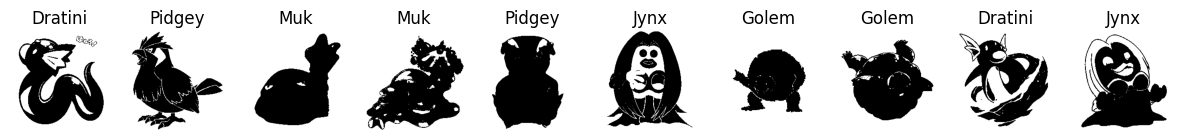

In [113]:
print(new_images.shape)

num_samples = 10
random_indices = random.sample(range(len(new_images)), num_samples)

fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i, idx in enumerate(random_indices):
    image = new_images[idx]
    label = new_labels[idx]
    label_name = pokemon_classes[label]
    np_image = (image.squeeze() * 255).astype(np.uint8)
    np_image = 255 - np_image
    axes[i].imshow(np_image,cmap='gray')
    axes[i].set_title(label_name)
    axes[i].axis('off')

plt.show()